<img src="../../images/arm_logo.png" width=500 alt="ARM Logo"></img>

# Advanced Displays with Py-ART - Bankhead National Forest
---

## Overview

Within this notebook, we will cover:
1. Using 3rd Party packages to create unique displays with Py-ART
1. Investigate the 20 May 2025 Hunstville, AL tornado with Py-ART

## Prerequisites
| Concepts | Importance | Notes |
| --- | --- | --- |
| [Py-ART Basics](pyart-basics) | Helpful | Basic features |
| [Weather Radar Basics](https://projectpythia.org/radar-cookbook/README.html) | Helpful | Background Information |
| [Matplotlib Basics](https://foundations.projectpythia.org/core/matplotlib/matplotlib-basics.html) | Helpful | Basic plotting |
| [NumPy Basics](https://foundations.projectpythia.org/core/numpy/numpy-basics.html) | Helpful | Basic arrays |
| [Xarray Basics](https://foundations.projectpythia.org/core/xarray.html) | Helpful | Multi-dimensional arrays |

- **Time to learn**: 15 minutes
---

## Imports

In [115]:
import os
import warnings
import glob
import tempfile
from math import atan2 as atan2

import numpy as np
from cartopy import crs as ccrs, feature as cfeature
from cartopy.io.img_tiles import GoogleTiles, OSM
from matplotlib.transforms import offset_copy
import matplotlib.pyplot as plt
from PIL import Image

import pyart
from pyart.testing import get_test_data
import xradar as xd

warnings.filterwarnings('ignore')

## Investigate the Available Data

In [92]:
DATE = "20250305"

In [94]:
file_list = sorted(glob.glob(f"/Users/jrobrien/ANL/Instruments/csapr2/bnf/*{DATE}*"))
file_list

['/Users/jrobrien/ANL/Instruments/csapr2/bnf/bnfcsapr2cmacS3.c1.20250305.010308.nc',
 '/Users/jrobrien/ANL/Instruments/csapr2/bnf/bnfcsapr2cmacS3.c1.20250305.010326.nc',
 '/Users/jrobrien/ANL/Instruments/csapr2/bnf/bnfcsapr2cmacS3.c1.20250305.011001.nc',
 '/Users/jrobrien/ANL/Instruments/csapr2/bnf/bnfcsapr2cmacS3.c1.20250305.011947.nc',
 '/Users/jrobrien/ANL/Instruments/csapr2/bnf/bnfcsapr2cmacS3.c1.20250305.012004.nc',
 '/Users/jrobrien/ANL/Instruments/csapr2/bnf/bnfcsapr2cmacS3.c1.20250305.012949.nc',
 '/Users/jrobrien/ANL/Instruments/csapr2/bnf/bnfcsapr2cmacS3.c1.20250305.013007.nc',
 '/Users/jrobrien/ANL/Instruments/csapr2/bnf/bnfcsapr2cmacS3.c1.20250305.013952.nc',
 '/Users/jrobrien/ANL/Instruments/csapr2/bnf/bnfcsapr2cmacS3.c1.20250305.014010.nc',
 '/Users/jrobrien/ANL/Instruments/csapr2/bnf/bnfcsapr2cmacS3.c1.20250305.015003.nc',
 '/Users/jrobrien/ANL/Instruments/csapr2/bnf/bnfcsapr2cmacS3.c1.20250305.015934.nc']

In [24]:
dt = xd.io.open_cfradial1_datatree(file_list[2])
dt

<xarray.DataTree>
Group: /
│   Dimensions:              (sweep: 15)
│   Dimensions without coordinates: sweep
│   Data variables:
│       sweep_group_name     (sweep) <U10 600B 'sweep_0.0' ... 'sweep_14.0'
│       sweep_fixed_angle    (sweep) float32 60B ...
│       latitude             float32 4B ...
│       longitude            float32 4B ...
│       altitude             float32 4B ...
│       time_coverage_start  |S22 22B ...
│       time_coverage_end    |S22 22B ...
│       volume_number        int32 4B ...
│   Attributes:
│       Conventions:  CF/Radial instrument_parameters ARM-1.3
│       institution:  United States Department of Energy - Atmospheric Radiation ...
│       references:   See CSAPR2 Instrument Handbook
│       comment:      This is highly experimental and initial data. There are man...
│       version:      2.0 lite
│       source:       Atmospheric Radiation Measurement (ARM) program C-band Scan...
│       history:      created by user rjackson on machine cirrus47.ccs.ornl.gov a...
├── Group: /sweep_0
│       Dimensions:                                                (azimuth: 361,
│                                                                   range: 1100)
│       Coordinates:
│           time                                                   (azimuth) datetime64[ns] 3kB ...
│         * range                                                  (range) float32 4kB ...
│         * azimuth                                                (azimuth) float32 1kB ...
│           elevation                                              (azimuth) float32 1kB ...
│           latitude                                               float32 4B ...
│           longitude                                              float32 4B ...
│           altitude                                               float32 4B ...
│       Data variables: (12/62)
│           time_offset                                            (azimuth) datetime64[ns] 3kB ...
│           attenuation_corrected_differential_reflectivity        (azimuth, range) float32 2MB ...
│           attenuation_corrected_differential_reflectivity_lag_1  (azimuth, range) float32 2MB ...
│           attenuation_corrected_reflectivity_h                   (azimuth, range) float32 2MB ...
│           censor_mask                                            (azimuth, range) int32 2MB ...
│           classification_mask                                    (azimuth, range) int32 2MB ...
│           ...                                                     ...
│           rain_rate_A                                            (azimuth, range) float64 3MB ...
│           sweep_number                                           float64 8B ...
│           sweep_fixed_angle                                      float32 4B ...
│           sweep_mode                                             <U6 24B 'sector'
│           prt                                                    (azimuth) float32 1kB ...
│           nyquist_velocity                                       (azimuth) float32 1kB ...
├── Group: /sweep_1
│       Dimensions:                                                (azimuth: 360,
│                                                                   range: 1100)
│       Coordinates:
│           time                                                   (azimuth) datetime64[ns] 3kB ...
│         * range                                                  (range) float32 4kB ...
│         * azimuth                                                (azimuth) float32 1kB ...
│           elevation                                              (azimuth) float32 1kB ...
│           latitude                                               float32 4B ...
│           longitude                                              float32 4B ...
│           altitude                                               float32 4B ...
│       Data variables: (12/62)
│           time_offset                                      

In [26]:
radar = pyart.xradar.Xradar(dt)
display = pyart.graph.RadarMapDisplay(radar)

In [77]:
radar.time["units"].split(" ")[3].split(".")[0]

'01:10:01'

In [78]:
radar.time["units"].split(" ")[2].replace("-", "") + "." + radar.time["units"].split(" ")[3].split(".")[0].replace(":", "")

'20250305.011001'

In [ ]:
np.datetime_as_string(ds_merged['valid_time'].data, unit='s').replace("T", "-").replace(":", "-")

## Bankhead National Forest Display Function

In [109]:
def gc_latlon_bear_dist(lat1, lon1, bear, dist):
    """
    Input lat1/lon1 as decimal degrees, as well as bearing and distance from
    the coordinate. Returns lat2/lon2 of final destination. Cannot be
    vectorized due to atan2.
    """
    re = 6371.1  # km
    lat1r = np.deg2rad(lat1)
    lon1r = np.deg2rad(lon1)
    bearr = np.deg2rad(bear)
    lat2r = np.arcsin((np.sin(lat1r) * np.cos(dist/re)) +
                      (np.cos(lat1r) * np.sin(dist/re) * np.cos(bearr)))
    lon2r = lon1r + atan2(np.sin(bearr) * np.sin(dist/re) *
                          np.cos(lat1r), np.cos(dist/re) - np.sin(lat1r) *
                          np.sin(lat2r))
    return np.rad2deg(lat2r), np.rad2deg(lon2r)
 
    
def add_scale_line(scale, ax, projection, color='k',
                  linewidth=None, fontsize=None, fontweight=None):
    """
    Adds a line that shows the map scale in km. The line will automatically
    scale based on zoom level of the map. Works with cartopy.
 
    Parameters
    ----------
    scale : scalar
        Length of line to draw, in km.
    ax : matplotlib.pyplot.Axes instance
        Axes instance to draw line on. It is assumed that this was created
        with a map projection.
    projection : cartopy.crs projection
        Cartopy projection being used in the plot.
 
    Other Parameters
    ----------------
    color : str
        Color of line and text to draw. Default is black.
    """
    frac_lat = 0.1  # distance fraction from bottom of plot
    frac_lon = 0.5  # distance fraction from left of plot
    e1 = ax.get_extent()
    center_lon = e1[0] + frac_lon * (e1[1] - e1[0])
    center_lat = e1[2] + frac_lat * (e1[3] - e1[2])
    # Main line
    lat1, lon1 = gc_latlon_bear_dist(
        center_lat, center_lon, -90, scale / 2.0)  # left point
    lat2, lon2 = gc_latlon_bear_dist(
        center_lat, center_lon, 90, scale / 2.0)  # right point
    if lon1 <= e1[0] or lon2 >= e1[1]:
        warnings.warn('Scale line longer than extent of plot! ' +
                      'Try shortening for best effect.')
    ax.plot([lon1, lon2], [lat1, lat2], linestyle='-',
            color=color, transform=projection, 
            linewidth=linewidth)
    # Draw a vertical hash on the left edge
    lat1a, lon1a = gc_latlon_bear_dist(
        lat1, lon1, 180, frac_lon * scale / 20.0)  # bottom left hash
    lat1b, lon1b = gc_latlon_bear_dist(
        lat1, lon1, 0, frac_lon * scale / 20.0)  # top left hash
    ax.plot([lon1a, lon1b], [lat1a, lat1b], linestyle='-',
            color=color, transform=projection, linewidth=linewidth)
    # Draw a vertical hash on the right edge
    lat2a, lon2a = gc_latlon_bear_dist(
        lat2, lon2, 180, frac_lon * scale / 20.0)  # bottom right hash
    lat2b, lon2b = gc_latlon_bear_dist(
        lat2, lon2, 0, frac_lon * scale / 20.0)  # top right hash
    ax.plot([lon2a, lon2b], [lat2a, lat2b], linestyle='-',
            color=color, transform=projection, linewidth=linewidth)
    # Draw scale label
    ax.text(center_lon, center_lat - frac_lat * (e1[3] - e1[2]) / 3.0,
            str(int(scale)) + ' km', horizontalalignment='center',
            verticalalignment='center', color=color, fontweight=fontweight,
            fontsize=fontsize)

In [125]:
def bnf_display(radar, 
                sweep=1, 
                var="reflectivity", 
                save=False, 
                outdir="./", 
                **kwargs):
    """
    Base layer display of Bankhead National Forest to project onto
    Py-ART displays

    Inputs
    ------
    radar : Py-ART (v2.0)  Radar Object
        Py-ART (v2.0) Radar  Object
    sweep : int
        specific sweep to plot within the display object
    var : str
        field within the radar object to display
    save : boolean
        boolean flag to save the data or not
    outdir : str
        path for location to save the data to

    Outputs
    -------
    display : Matplotlib Figure

    """
    STATUS = "File Not Saved"
    # Define the sites to display
    M1 = [34.34525, -87.33842]
    S4 = [34.46451,	-87.23598]
    S3 = [34.63080, -87.13311]
    S20 = [34.65401, -87.29264]
    S30	= [34.38501, -86.92757]
    S40	= [34.17932, -87.45349]

    sites = dict({"M1" : M1,
                  "S4" : S4,
                  "S20" : S20,
                  "S30" : S30,
                  "S40" : S40,
                  "CSAPR-2" : S3}
    )

    # define the center of the map to be the CSAPR2
    central_lon = -87.13076
    central_lat = 34.63080

    # Set up the figure
    fig = plt.figure(figsize=(16, 8))
    # Initialize OpenStreetMap tile
    tiler = OSM()
    # Create a subplot and define projection
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

    display = pyart.graph.RadarMapDisplay(radar)
    # Add the reflectivity variable
    display.plot_ppi_map(var, 
                         sweep=sweep, 
                         ax=ax, 
                         cmap="ChaseSpectral",
                         **kwargs
    )

    ims = display.plots[0]
    cbar = fig.colorbar(ims, ax=ax, location="bottom", shrink=0.6, pad=0.1)
    cbar.set_label("Equivalent Reflectivity Factor [dBZ]")

    # Add some various map elements to the plot to make it recognizable.
    # Initialize OpenStreetMap tile
    tiler = OSM()
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.STATES)
    ax.add_feature(cfeature.BORDERS)
    ax.add_image(tiler, 9, zorder=1, alpha=0.45)
    # Set the BNF Domain (adjust later for various groups)
    ax.set_extent([272.0, 274.0, 35.1, 34.1])
    ax.gridlines(draw_labels=True)

    # Add the scale line
    add_scale_line(35.0, 
                   ax, 
                   projection=ccrs.PlateCarree(), 
                   linewidth=3,
                   fontsize=14,
                   fontweight='bold')

    # add in the site locations
    for key in sites:
        ax.plot(sites[key][1], 
                sites[key][0], 
                marker='s', 
                color='black', 
                markersize=8, 
                alpha=0.7, 
                transform=ccrs.PlateCarree())
        
        # Use the cartopy interface to create a matplotlib transform object
        # for the Geodetic coordinate system. We will use this along with
        # matplotlib's offset_copy function to define a coordinate system which
        # translates the text by 25 pixels to the left.
        geodetic_transform = ccrs.PlateCarree()._as_mpl_transform(ax)
        text_transform = offset_copy(geodetic_transform, units='dots', x=+50, y=+15)

        if key == "CSAPR-2":
            # Add text 25 pixels to the left of the volcano.
            ax.text(sites[key][1]+0.03, 
                    sites[key][0]+0.035, 
                    "CSAPR-2", 
                    verticalalignment='center', 
                    horizontalalignment='right', 
                    transform=text_transform,
                    bbox=dict(facecolor='sandybrown', 
                    alpha=0.5, 
                    boxstyle='round'))
        else:
            # Add text 25 pixels to the left of the volcano.
            ax.text(sites[key][1]-0.11, 
                    sites[key][0], 
                    key, 
                    verticalalignment='center', 
                    horizontalalignment='left', 
                    transform=text_transform,
                    bbox=dict(facecolor='sandybrown', 
                    alpha=0.5, 
                    boxstyle='round'))

    # Add a legend
    # Place a legend to the right of this smaller subplot.
    fig.legend(loc='right')

    # Set the DPI to a higher value (e.g., 300)
    plt.rcParams['figure.dpi'] = 300
    plt.rcParams['savefig.dpi'] = 300

    if save:
        try:
            out_time = (radar.time["units"].split(" ")[2].replace("-", "") +
            "-" +
            radar.time["units"].split(" ")[3].split(".")[0].replace(":", ""))
            fig.savefig(outdir + 
                    'csapr2-bnf-display-' + 
                    out_time +
                    '.png')
            plt.close(fig)
            STATUS = "SUCCESS"
        except:
            STATUS = "FAILURE"
    
    return STATUS

'File Not Saved'

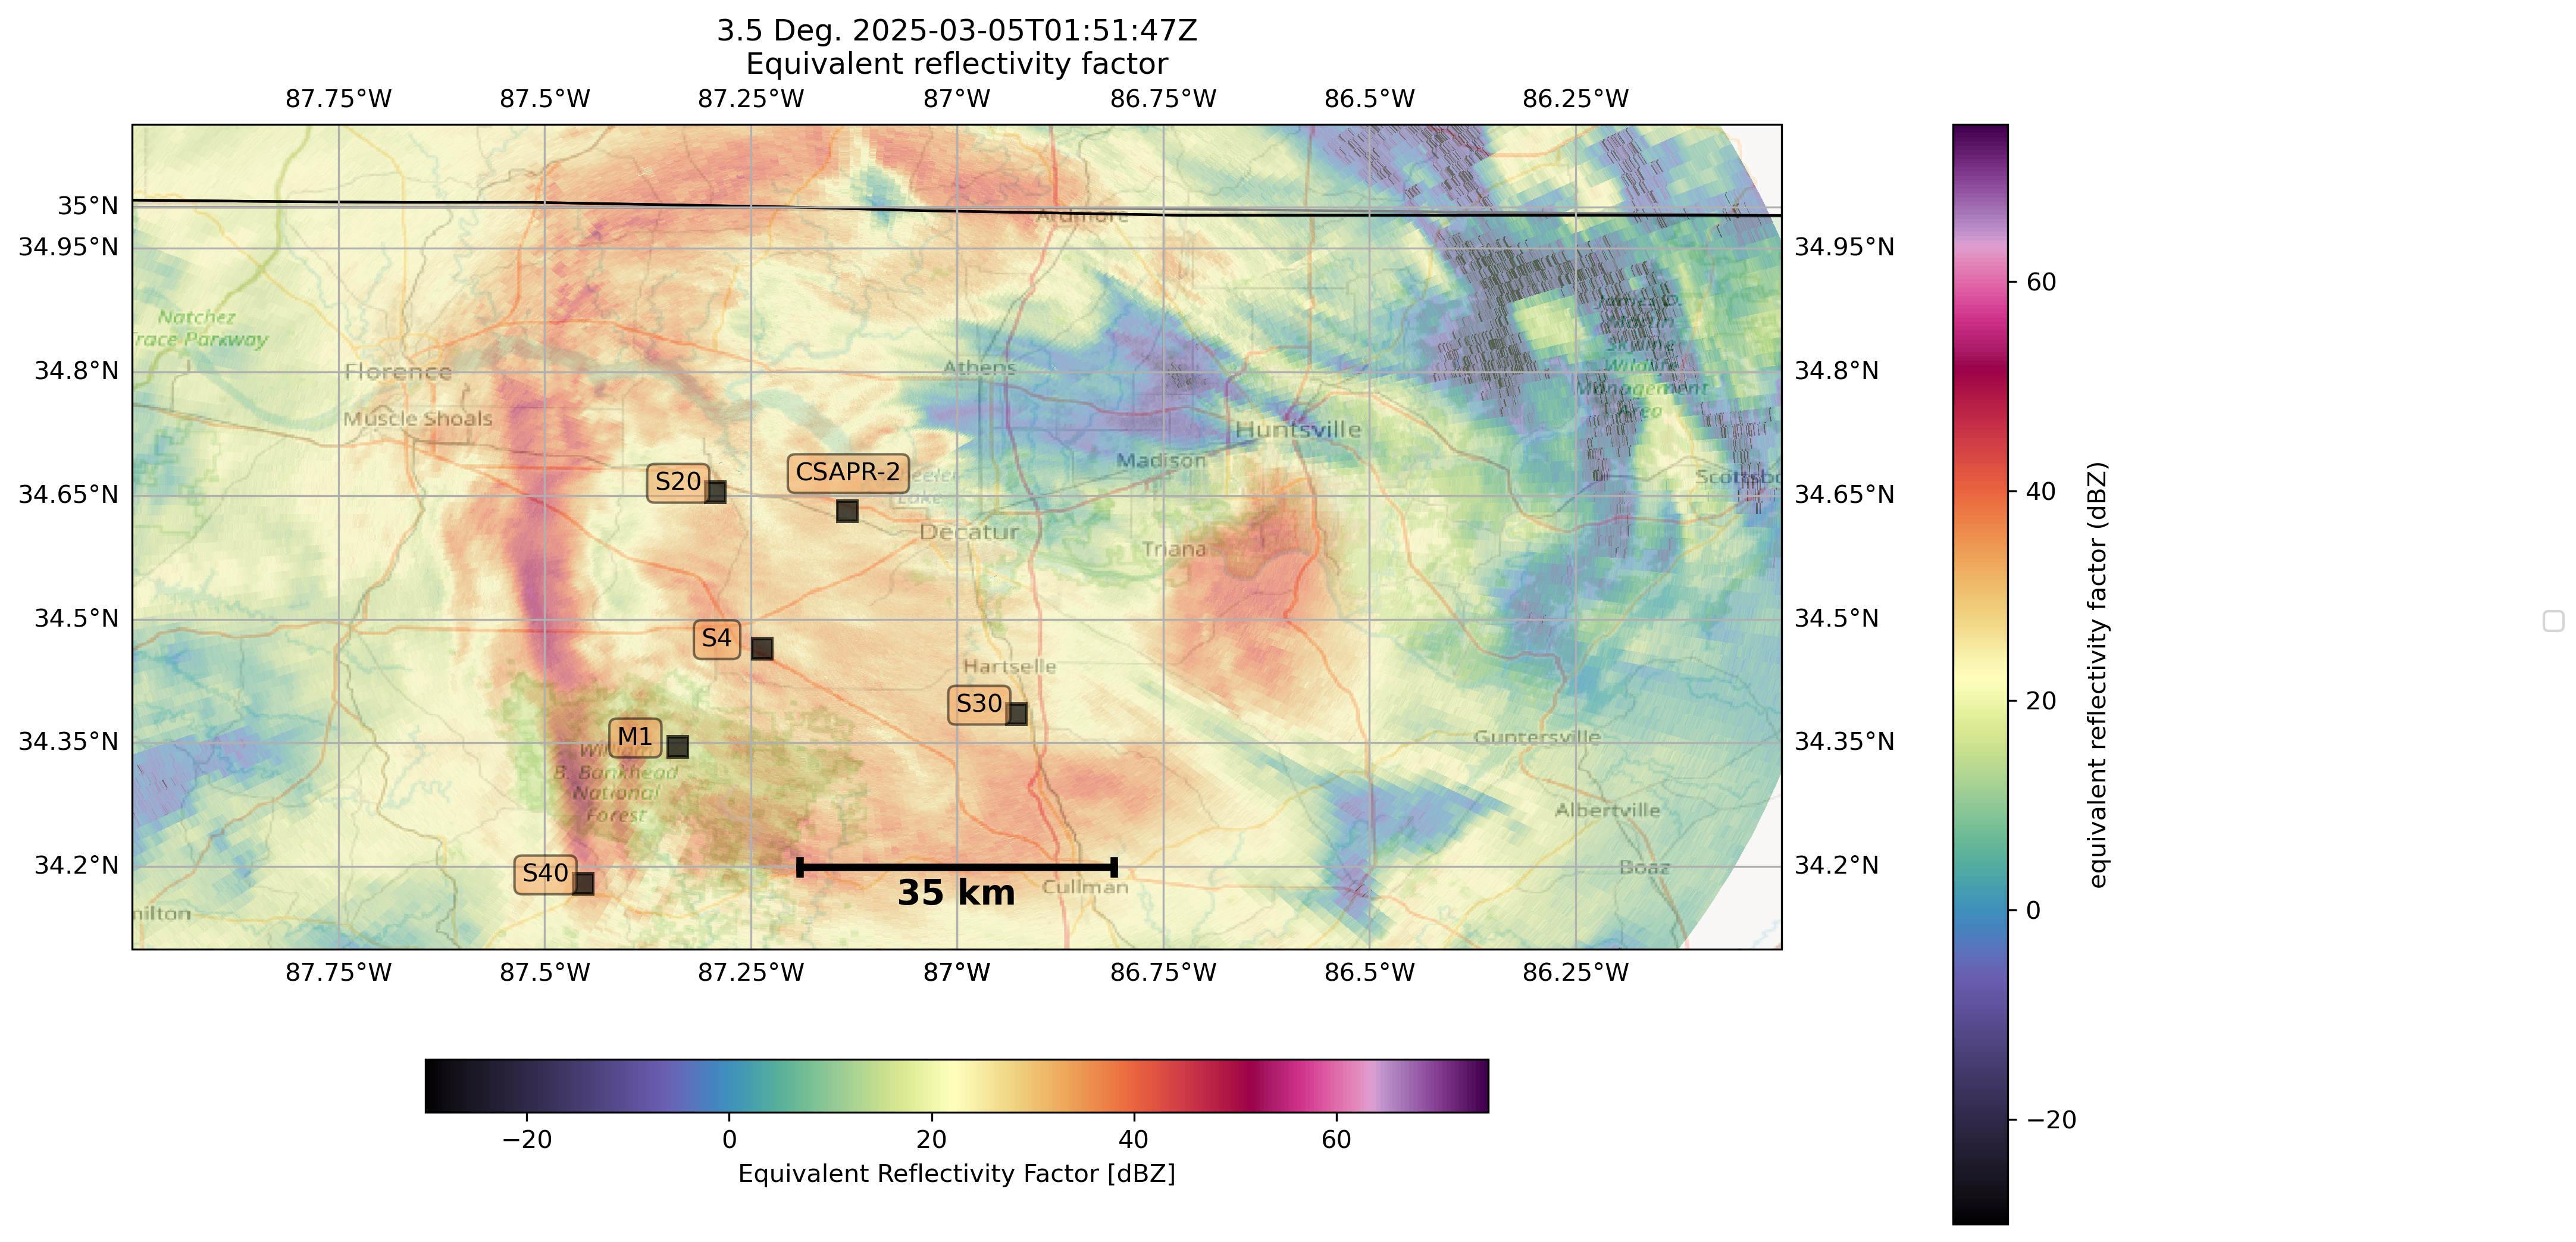

In [126]:
bnf_display(radar, sweep=2, save=False, outdir="./")

## Create a GIF to showcase multiple scans

In [95]:
def create_gif(path, outdir, date):
    # Define files created and define movie path
    map_images = sorted(glob.glob(path + f"csapr2-bnf-display-*"))
    gif_title = outdir + f"csapr2-bnf-display-" + date + ".gif"

    # Check to see if the file exists - if it does, delete it
    if os.path.exists(gif_title):
        os.remove(gif_title)

    # Step 2: Open images using Pillow
    frames = [Image.open(f) for f in map_images]

    # Step 3: Save as GIF with 2.5s per frame
    frames[0].save(
        gif_title,
        save_all=True,
        append_images=frames[1:],
        duration=850,  # Duration in ms
        loop=0          # Loop forever
    )

In [106]:
templocation = tempfile.mkdtemp() + "/"
for i in range(len(file_list)):
    try:
        dt = xd.io.open_cfradial1_datatree(file_list[i])
        radar = pyart.xradar.Xradar(dt)
        bnf_display(radar, sweep=2, save=True, outdir=templocation)
    except:
        pass

create_gif(templocation, "./", DATE)
